In [1]:
from openpyxl import Workbook
from downstream.fidelity_predict.evaluate_tools import plot_top_ratio
from plot.plot import get_duration2circuit_infos
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration
from circuit.utils import make_circuitlet
from generate_dataset import gen_train_dataset
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path, plot_correlation, plot_real_predicted_fidelity
import random
import numpy as np

from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator, get_random_erroneous_pattern
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle
import os
from sklearn.model_selection import train_test_split

size = 10
n_qubits = 100
n_steps = 1

topology = gen_grid_topology(size)  # 3x3 9 qubits
new_topology = defaultdict(list)
for qubit in topology.keys():
    if qubit < n_qubits:
        for ele in topology[qubit]:
            if ele < n_qubits:
                new_topology[qubit].append(ele)
topology = new_topology
neighbor_info = copy.deepcopy(topology)
coupling_map = topology_to_coupling_map(topology)


backend = Backend(n_qubits=n_qubits, topology=topology, neighbor_info=neighbor_info, basis_single_gates=default_basis_single_gates,
                  basis_two_gates=default_basis_two_gates, divide=False, decoupling=False)


regen = False
if regen:
    dataset = gen_train_dataset(n_qubits, topology, neighbor_info, coupling_map, dataset_size = 5000,min_cut_qubit=2,devide_size=5)

    test_dataset = gen_train_dataset(n_qubits, topology, neighbor_info, coupling_map, dataset_size = 1000,min_cut_qubit=2,devide_size=5)


    print('train dataset size = ', len(dataset))
    print('test dataset size = ', len(test_dataset))

    upstream_model = RandomwalkModel(
        n_steps, 20, backend=backend, travel_directions=('parallel', 'former'))
    
    upstream_model.train(dataset + test_dataset, multi_process=True,
                         remove_redundancy=n_steps > 1)

    dataset_cut = make_circuitlet(dataset)
    print("cutted", len(dataset_cut))
    
    test_dataset_cut = make_circuitlet(test_dataset)
    print("cutted", len(test_dataset_cut))
    
    all_to_all_backend = Backend(n_qubits=5, topology=None, neighbor_info=neighbor_info, basis_single_gates=default_basis_single_gates,
                  basis_two_gates=default_basis_two_gates, divide=False, decoupling=False)
            
    simulator = NoiseSimulator(all_to_all_backend)
    erroneous_pattern = get_random_erroneous_pattern(
        upstream_model, error_pattern_num_per_device=3)
    
    # 每个subcircuit是单独的NoiseSimulator，backend对应不对
    erroneous_pattern = simulator.get_error_results(
        dataset_cut + test_dataset_cut, upstream_model, multi_process=True, erroneous_pattern=erroneous_pattern)
    upstream_model.erroneous_pattern = erroneous_pattern

    with open(f"simulate_50_350/{n_qubits}/upstream_model.pkl", "wb")as f:
        pickle.dump(upstream_model, f)

    train_dataset, validation_dataset = train_test_split(dataset_cut, test_size = .2)
    
    test_dataset = np.array(test_dataset_cut)

    with open(f"simulate_50_350/{n_qubits}/dataset.pkl", "wb")as f:
        pickle.dump((train_dataset, validation_dataset, test_dataset), f)

else:
    with open(f"simulate_50_350/{n_qubits}/dataset.pkl", "rb")as f:
        train_dataset, validation_dataset, test_dataset = pickle.load(f)

    with open(f"simulate_50_350/{n_qubits}/upstream_model.pkl", "rb")as f:
        upstream_model = pickle.load(f)

total_dataset = np.concatenate([train_dataset, validation_dataset, test_dataset])


In [22]:
with open(f"simulate_50_350/{n_qubits}/dataset.pkl", "wb")as f:
        pickle.dump((train_dataset, validation_dataset, test_dataset), f)

In [20]:
_filtered_dataset = []
_idxs = []
for idx, cir in enumerate(test_dataset):
    if cir['ground_truth_fidelity'] < .2:
        _filtered_dataset.append(cir)
        _idxs.append(idx)


In [21]:
len(_filtered_dataset),len(_idxs)

(0, 0)

In [11]:
len(filtered_dataset),len(idxs)

(18180, 18180)

In [12]:
all_to_all_backend = Backend(n_qubits=5, topology=None, neighbor_info=neighbor_info, basis_single_gates=default_basis_single_gates,
                  basis_two_gates=default_basis_two_gates, divide=False, decoupling=False)
            
simulator = NoiseSimulator(all_to_all_backend)
erroneous_pattern = upstream_model.erroneous_pattern
simulator.get_error_results(filtered_dataset, upstream_model,erroneous_pattern=erroneous_pattern, multi_process = True)


2023-03-31 15:48:43,267	INFO worker.py:1538 -- Started a local Ray instance.


(get_error_result_remote pid=1787688) call latency =  1.6101579666137695 s
(get_error_result_remote pid=1787678) call latency =  11.969913244247437 s
(get_error_result_remote pid=1787813) call latency =  1.569000005722046 s
(get_error_result_remote pid=1787685) call latency =  1.5603909492492676 s
(get_error_result_remote pid=1790269) call latency =  1.4609081745147705 s
(get_error_result_remote pid=1790520) call latency =  1.599088191986084 s
(get_error_result_remote pid=1790191) call latency =  1.6209416389465332 s
(get_error_result_remote pid=1787673) call latency =  1.4759042263031006 s
(get_error_result_remote pid=1787818) call latency =  1.3778891563415527 s
(get_error_result_remote pid=1787666) call latency =  1.6565678119659424 s
(get_error_result_remote pid=1790017) call latency =  1.3207974433898926 s
(get_error_result_remote pid=1787949) call latency =  1.4518005847930908 s
(get_error_result_remote pid=1789697) call latency =  1.6884453296661377 s
(get_error_result_remote pi

defaultdict(list,
            {0: ['ry,0-parallel-ry,1',
              'rx,0-parallel-cz,1,11',
              'ry,0-former-cz,0,10'],
             1: ['rx,1-former-cz,0,10', 'rx,1-former-cz,2,12'],
             2: ['rx,2-former-cz,0,1'],
             3: ['rx,3-former-cz,4,14', 'rx,3-parallel-ry,2'],
             4: ['rx,4-parallel-rx,5'],
             5: ['ry,5-former-cz,5,6', 'ry,5-former-cz,15,25'],
             6: ['ry,6-parallel-cz,7,17',
              'rx,6-parallel-cz,4,5',
              'rx,6-parallel-rx,5'],
             7: ['ry,7-parallel-cz,5,6'],
             8: [],
             9: ['rx,9-former-cz,9,19'],
             10: ['rx,10-former-cz,10,20', 'rx,10-parallel-cz,0,1'],
             11: ['rx,11-former-cz,11,21', 'rx,11-former-rx,10'],
             12: [],
             13: ['rx,13-former-rx,13',
              'ry,13-parallel-ry,12',
              'rx,13-parallel-rx,3'],
             14: ['rx,14-parallel-ry,4',
              'ry,14-former-cz,15,25',
              'ry,14-fo

In [13]:
for cir in filtered_dataset:
    print(cir['ground_truth_fidelity'])

0.7025000000000001
0.939
0.8566666666666666
0.8966666666666668
0.9095
0.8221666666666666
0.904
0.8498333333333333
0.9753333333333334
0.9058333333333334
0.8645
0.8893333333333334
0.9448333333333334
0.9356666666666665
0.8005
0.8315
0.8226666666666667
0.9146666666666666
0.8375
0.8053333333333333
0.8903333333333333
0.7885
0.9088333333333333
0.8478333333333333
0.7491666666666666
0.9291666666666667
0.7531666666666667
0.8076666666666666
0.8889999999999999
0.8371666666666667
0.7556666666666668
0.8891666666666667
0.9216666666666667
0.654
0.7305
0.9414999999999999
0.9301666666666667
0.6805
0.6426666666666666
0.8291666666666666
0.8846666666666666
0.9419999999999998
0.8961666666666667
0.8211666666666667
0.9705
0.9245
0.9073333333333333
0.936
0.9593333333333333
0.8456666666666667
0.8853333333333332
0.9830000000000001
0.8558333333333333
0.8998333333333334
0.8803333333333335
0.9706666666666668
0.7015000000000001
0.9811666666666667
0.9065
0.8096666666666668
0.9815
0.7010000000000001
0.8563333333333333

In [25]:
single_average_error = {0: 0.0007773602641497784, 1: 0.0006209312562346627, 2: 0.0006812330197817958, 3: 0.0005829563100280716, 4: 0.0007041094015115584, 5: 0.0005854677268585807, 6: 0.0006447537453549731, 7: 0.0005576175341573022, 8: 0.0006243070696337213, 9: 0.0006459654488258894, 10: 0.0006484696368035301, 11: 0.0006994711567090423, 12: 0.0006192033611051846, 13: 0.0007923874827156385, 14: 0.0006596555069244677, 15: 0.0006256071998275135, 16: 0.0007059190046321103, 17: 0.0006866673532815886, 18: 0.0005993770769506141, 19: 0.0006312677160410369, 20: 0.0006694209282521466, 21: 0.0006446262119496887, 22: 0.000648107013744596, 23: 0.0006167513021540932, 24: 0.0006707252180780462, 25: 0.0007536367232423745, 26: 0.0005988209988885909, 27: 0.0006732718978846783, 28: 0.0006224929575278468, 29: 0.0006152508800676426, 30: 0.0006187725019056724, 31: 0.00065355082314834, 32: 0.0006171559410741082, 33: 0.0005679676113231078, 34: 0.0006172244329986756, 35: 0.0006595604089040893, 36: 0.0006990926457118552, 37: 0.0007823910494448119, 38: 0.000657993971500911, 39: 0.000752501048732675, 40: 0.000572323611446382, 41: 0.0005753574557476578, 42: 0.0007599777246586653, 43: 0.0007039235848384649, 44: 0.0005845160136915012, 45: 0.0006269828088259534, 46: 0.0007137787412400005, 47: 0.0006075166542339234, 48: 0.0005121017849790267, 49: 0.0006484377395191899, 50: 0.0005421034146204195, 51: 0.0006402777130080835, 52: 0.0005974528693742237, 53: 0.0006514577161700305, 54: 0.0006649697524532794, 55: 0.0005185255015367269, 56: 0.0006605422685154449, 57: 0.000634741244369293, 58: 0.0007336544214617577, 59: 0.0006740035721409308, 60: 0.0006979130698123823, 61: 0.0008576158948158189, 62: 0.0007185254212739106, 63: 0.0006239725905787317, 64: 0.0005606983651245795, 65: 0.0006147414041658417, 66: 0.0006811677492447564, 67: 0.0006661357281921397, 68: 0.0006087721518023878, 69: 0.0005761657135320783, 70: 0.00061123940599545, 71: 0.0006258784280476783, 72: 0.000656784333610743, 73: 0.0007467283096305977, 74: 0.0006994008181522747, 75: 0.0005716364809403295, 76: 0.0007112310710440927, 77: 0.0006992510929145243, 78: 0.0007243642283944397, 79: 0.0007873276006422449, 80: 0.0005750590538311026, 81: 0.0006533254441201836, 82: 0.0006094322952730699, 83: 0.0006970076774445613, 84: 0.0006707919634895748, 85: 0.0006789885255972516, 86: 0.0007217288981879182, 87: 0.000722994222365777, 88: 0.0005455889339485182, 89: 0.0006700775560181057, 90: 0.0005999347978345914, 91: 0.0005994170006054789, 92: 0.0007396928404432986, 93: 0.0005633290554605602, 94: 0.0007174224254768241, 95: 0.000591256021286274, 96: 0.0006873851268203129, 97: 0.0006746965537373268, 98: 0.0007064768716886162, 99: 0.0004985478712973509}

In [26]:
couple_average_error = {(72, 73): 0.001606478743485715, (7, 17): 0.0016199622379877696, (62, 72): 0.0014070352556266614, (67, 68): 0.0018822248103968057, (72, 82): 0.001900692616267836, (44, 45): 0.002011634134528752, (67, 77): 0.0016332250778120178, (44, 54): 0.001970843620518055, (3, 13): 0.001665327551908076, (8, 9): 0.0017696209650533278, (40, 41): 0.002110632170904297, (8, 18): 0.002014173481942446, (40, 50): 0.002324163010819494, (36, 46): 0.0014916528454828066, (41, 42): 0.0014439270165882527, (96, 97): 0.001691823823352956, (18, 19): 0.0018803330038738453, (73, 74): 0.0014566102530290815, (41, 51): 0.001714051193613976, (18, 28): 0.002063505815941756, (73, 83): 0.0017901835923759524, (14, 15): 0.0016042802354961658, (14, 24): 0.0015845976208642564, (74, 75): 0.0017473789645306638, (9, 19): 0.0018391411460056191, (74, 84): 0.0016302953803028312, (10, 20): 0.001697240318932061, (15, 16): 0.0015204411925523668, (47, 48): 0.0019905877335221842, (15, 25): 0.0018280608993968593, (42, 43): 0.0014973125667113456, (47, 57): 0.0022248950854357017, (42, 52): 0.0018561035492391412, (38, 39): 0.00179301537840154, (48, 49): 0.001988799397360319, (38, 48): 0.002149353973618128, (80, 81): 0.0018325784991185701, (48, 58): 0.0018368011488926435, (75, 76): 0.001788473295816727, (80, 90): 0.0015043951082850287, (85, 86): 0.0017346424179436914, (75, 85): 0.0014820456081591213, (16, 17): 0.0016113988807096437, (71, 72): 0.0018543643325445768, (81, 82): 0.0018926040228697887, (16, 26): 0.0019501191797780496, (71, 81): 0.002126187084006918, (81, 91): 0.0015757158857172455, (12, 13): 0.001351877361545428, (22, 23): 0.0017953967067743477, (77, 78): 0.0014738568978466178, (12, 22): 0.0019086333958865354, (22, 32): 0.0017269586013206896, (77, 87): 0.0016544591209107042, (49, 59): 0.0018174561221599246, (13, 14): 0.0015311444705677073, (45, 46): 0.001615996457464197, (13, 23): 0.0014901423094394392, (55, 56): 0.0020041001791820225, (45, 55): 0.002016641172437393, (50, 51): 0.001951293621372148, (55, 65): 0.002179092011448553, (82, 83): 0.0019484040541374442, (82, 92): 0.0014852500963636345, (51, 52): 0.0018261720712829952, (46, 47): 0.001758737698462349, (51, 61): 0.0011981663787198082, (23, 24): 0.0023367760093976676, (78, 79): 0.0013785058863154188, (46, 56): 0.0017974311014900138, (23, 33): 0.001693963809516391, (78, 88): 0.0017174117513729169, (83, 84): 0.0015322152602187836, (19, 29): 0.0013613485297212658, (24, 25): 0.0016898422462973354, (56, 57): 0.0020136549469991416, (79, 89): 0.0014035575753901374, (56, 66): 0.0015676304767020875, (20, 21): 0.0019705828754509012, (52, 53): 0.0016158359533456684, (20, 30): 0.0016455001417406958, (52, 62): 0.0018601316698796469, (57, 58): 0.001748440634040532, (89, 99): 0.0020968942097117846, (53, 54): 0.0018330395099494228, (30, 31): 0.00207839634589256, (53, 63): 0.0016555627364117584, (25, 26): 0.0018719195278591987, (30, 40): 0.0018656061219716445, (85, 95): 0.0016401925434811678, (90, 91): 0.002250416231240307, (25, 35): 0.0018733874091239344, (26, 27): 0.0022065328181305843, (21, 22): 0.001925255484476236, (26, 36): 0.0016048208653684627, (31, 32): 0.0017525498987922953, (86, 87): 0.001754524126316608, (21, 31): 0.001804521173742015, (86, 96): 0.0018021365770417453, (17, 18): 0.0018561371573097842, (27, 28): 0.0017727732688400655, (17, 27): 0.0015298816179738248, (27, 37): 0.0012732257353679102, (54, 55): 0.001893056337961108, (64, 65): 0.0018326703072759551, (54, 64): 0.0019162865179698626, (5, 6): 0.001857796974110738, (60, 61): 0.0014991547085362095, (50, 60): 0.0019172949294656069, (60, 70): 0.002045369014361712, (87, 88): 0.0018220026874700558, (97, 98): 0.0017872526666578902, (87, 97): 0.0017646863064746585, (1, 2): 0.0021277100194363407, (1, 11): 0.0017388633804992742, (28, 29): 0.0016615266525777696, (93, 94): 0.0014498562287542887, (28, 38): 0.0018542180871989845, (83, 93): 0.0020069281914108397, (88, 89): 0.002063184412949643, (88, 98): 0.0019153080689603727, (24, 34): 0.0020289802107618317, (84, 85): 0.0016107310338870694, (61, 62): 0.001307651423595863, (84, 94): 0.0016497161999502721, (61, 71): 0.0014487296722485404, (2, 3): 0.0017028333837382224, (2, 12): 0.0019302768183152414, (57, 67): 0.0019914908873449664, (62, 63): 0.0019204747048767407, (94, 95): 0.001875569659831934, (3, 4): 0.0022510970318284345, (58, 59): 0.0016664425633352393, (35, 36): 0.0016010159942709847, (58, 68): 0.0018828895155586513, (35, 45): 0.0018953386091249405, (95, 96): 0.0019171245418858071, (31, 41): 0.001988663921109901, (36, 37): 0.0014104452876725782, (91, 92): 0.0020805893912191893, (68, 69): 0.0019605767846960997, (63, 64): 0.0015706161485132442, (68, 78): 0.0018692895047733272, (63, 73): 0.0017379144638897742, (32, 33): 0.001940520121438997, (32, 42): 0.0017568263480042714, (4, 5): 0.0018780540003826933, (64, 74): 0.0019075568306371202, (4, 14): 0.0020128415430932037, (59, 69): 0.0017029002184504763, (69, 79): 0.0017794397397701636, (0, 1): 0.0018746178622161861, (5, 15): 0.0020852822623473547, (10, 11): 0.0017147559627423252, (65, 66): 0.00188950455959098, (0, 10): 0.0015727243864838776, (65, 75): 0.001939966577366811, (37, 38): 0.001551796568062411, (92, 93): 0.0015648906546341039, (37, 47): 0.001882399358748133, (6, 7): 0.0021755118813212627, (6, 16): 0.0018690352236311507, (33, 34): 0.0021836924792024022, (43, 44): 0.0015178911065288538, (98, 99): 0.0017701776943808182, (33, 43): 0.0018568013148536559, (43, 53): 0.0018886201355778527, (70, 71): 0.002063600909273418, (70, 80): 0.0021795872665206465, (29, 39): 0.0015255157296827923, (34, 35): 0.0018985451510287843, (39, 49): 0.0019391159823356674, (11, 12): 0.0016232057735733221, (66, 67): 0.001766057176178164, (34, 44): 0.0018404885124172843, (76, 77): 0.001696973509563198, (11, 21): 0.0011476261498826793, (66, 76): 0.00174563549125918, (76, 86): 0.001272617488199385, (7, 8): 0.001922424488569423}

In [27]:
with open(f"simulate_50_350/{n_qubits}/rb_error.pkl", "wb")as f:
    pickle.dump((single_average_error, couple_average_error), f)

In [28]:
from upstream.randomwalk_model import extract_device
def get_xeb_fidelity(circuit_info):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device, tuple):
            device = (circuit_info['map'][device[0]],
                      circuit_info['map'][device[1]])
            fidelity = fidelity * (1 - couple_average_error[device])
        else:
            device = circuit_info['map'][device]
            fidelity = fidelity * (1 - single_average_error[device])
    # * np.product((measure0_fidelity + measure1_fidelity) / 2)
    return fidelity

average inaccuracy =  0.06832685858731688


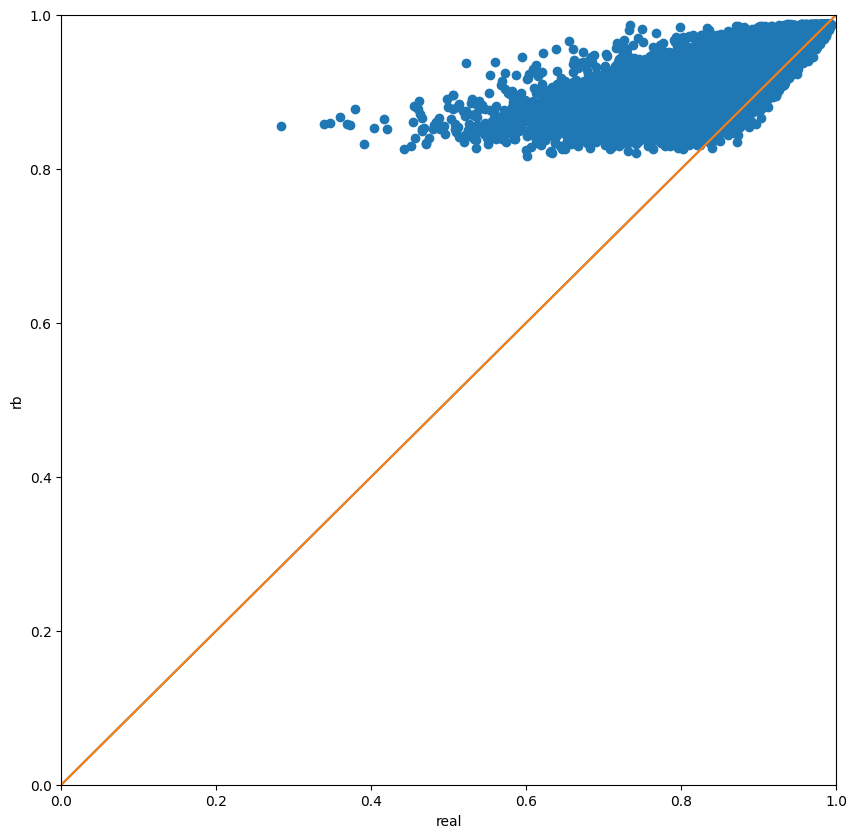

In [30]:
xebs,reals = [],[]
for cir in test_dataset:
    xebs.append(get_xeb_fidelity(cir))
    reals.append(cir['ground_truth_fidelity'])

xebs = np.array(xebs)

print('average inaccuracy = ', np.abs(xebs - reals).mean())

fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, xebs)
axes.set_xlabel('real')
axes.set_ylabel('rb')
axes.plot([[0, 0], [1, 1]])
fig.savefig(f"simulate_50_350/{n_qubits}/real_rb_{n_qubits}_step1.svg")


In [1]:
n_qubits = 100
import pickle 
with open(f"simulate_50_350/{n_qubits}/error_params_predicts_{n_qubits}.pkl", "rb")as f:
    downstream_model, predicts, reals, durations, test_dataset = pickle.load(f)
upstream_model = downstream_model.upstream_model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
from plot.plot import  find_error_path

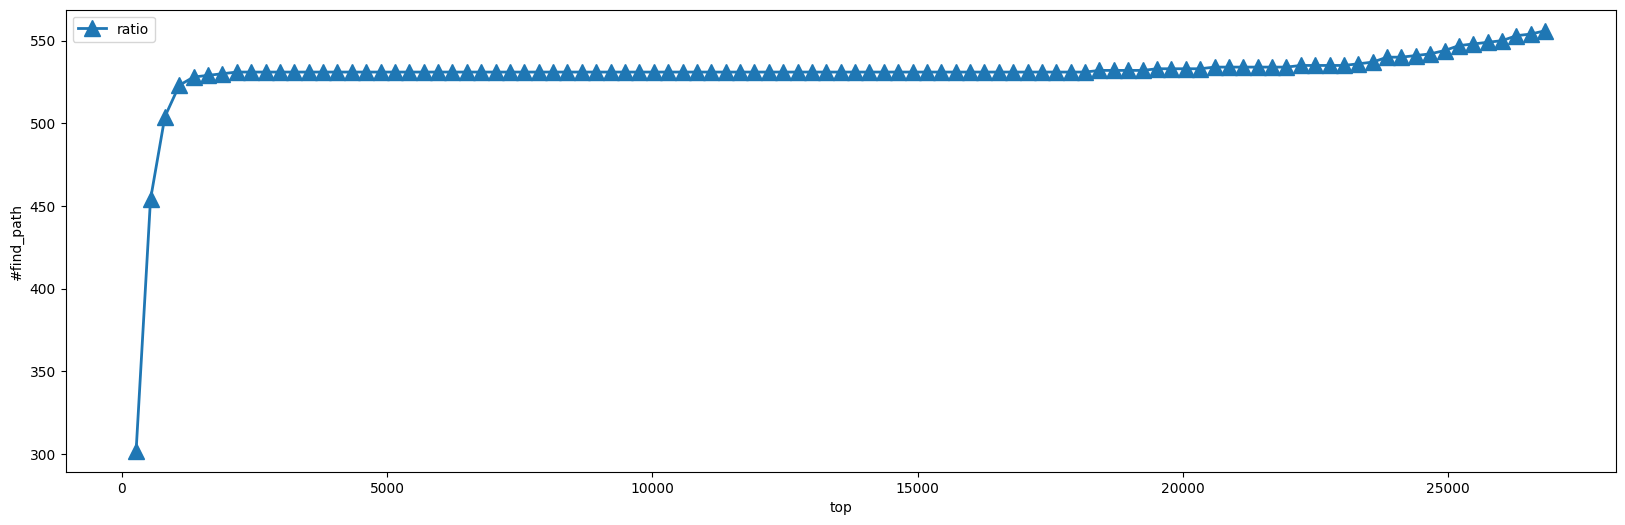

In [3]:
find_error_path(upstream_model, downstream_model.error_params['gate_params'],name = f"simulate_50_350/{n_qubits}/find_ratio.png")